# Additional Cell Lines

# Setup

In [1]:
# Uses hicdash v0.0.3.1 (packaged)
import hicdash
from hicdash.definitions import *
from hicdash.constants import *
from hicdash.utilities import *
from hicdash.plotters import *

In [2]:
from dataclasses import replace
from collections import defaultdict
from collections import Counter
import pandas as pd
import os

import pyBigWig

plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = "sans-serif"

In [3]:
def get_min_max(letter, biotype_prefix="IG", strip_prefix="IGH", contig="14", start=105586437, end=106879844):
    in_locus = GENE_ANNOTATIONS.genes_at_locus(contig, start, end)
    igh_genes = [ g for g in in_locus if g.biotype == f"{biotype_prefix}_{letter}_gene" and g.gene_name.startswith(strip_prefix)]
    rects = [(x.gene_name.replace(strip_prefix, ""), x.start, x.end) for x in igh_genes if x.gene_name.startswith(strip_prefix)]
    igh_min = min(map(lambda x: x.start, igh_genes))
    igh_max = max(map(lambda x: x.end, igh_genes))
    return (igh_min, igh_max, rects)

IGH_LOCUS = { letter: get_min_max(letter, strip_prefix="IGH") for letter in "VDJC" }
IGH_REGION = GenomicRegion("chr14", 105586437, 106879844)

IGL_LOCUS = { letter : get_min_max(letter, contig="22", start=22026076, end=22922913, strip_prefix="IGL") for letter in "VJC" }
IGL_REGION = GenomicRegion("chr22", start=22026076, end=22922913)

IGK_LOCUS = { letter : get_min_max(letter, contig="2", start=88857361, end=90235368, strip_prefix="IGK") for letter in "VJC" }
IGK_REGION = GenomicRegion("chr2", start=88857361, end=90235368)

TRA_LOCUS = { letter : get_min_max(letter, biotype_prefix="TR", contig="14", start=21621904, end=22552132, strip_prefix="TRA") for letter in "VJC" }
TRA_REGION = GenomicRegion("chr14", start=21621904, end=22552132)

LOCUS_COLORS = {
    "V": "#7d2424",
    "D": "#346634",
    "J": "#2a2a73",
    "C": "black"
}

In [4]:
def plot_gene_track_autospecial(region: GenomicRegion, ax: plt.Axes, label_side=False, vertical=False, **kwargs):
    fontsize=12 if "fontsize" not in kwargs.keys() else kwargs["fontsize"]
    autolabel = None
    autoregion = None
    autolocus = None
    if region.overlaps(IGH_REGION):
        autolabel = "IGH Locus"
        autolocus = IGH_LOCUS
        autoregion = IGH_REGION
    elif region.overlaps(IGL_REGION):
        autolabel = "IGL Locus"
        autolocus = IGL_LOCUS
        autoregion = IGL_REGION
    elif region.overlaps(IGK_REGION):
        autolabel = "IGK Locus"
        autolocus = IGK_LOCUS
        autoregion = IGK_REGION
    elif region.overlaps(TRA_REGION):
        autolabel = "TRA Locus"
        autolocus = TRA_LOCUS
        autoregion = TRA_REGION
        
    
    if autolabel is not None and autolocus is not None:
        ax_lim = 5
        blank_axis(ax)
        text_mid_start = autoregion.start if region.start < autoregion.start < region.end else region.start
        text_mid_end = autoregion.end if region.start < autoregion.end  < region.end else region.end
        text_mid = (text_mid_start + text_mid_end) / 2
        if vertical:
            ax.set_ylim(region.end, region.start)
            ax.text(4, text_mid, autolabel, rotation=90, fontsize=fontsize, ha="right", va="center")
            for letter, (rmin, rmax, rects) in autolocus.items():
                mid = (max(rmin, region.start) + min(rmax, region.end)) / 2
                color = LOCUS_COLORS[letter]
                ax.vlines(0.75, rmin, rmax, colors=color, ls=":", lw=0.5)
                if letter != "C" or region.get_size() > 300000:
                    ax.text(4, mid, letter, ha="left", va="center", rotation=90, fontsize=7, color=color, clip_on=True)
                for (gene_name, rectmin, rectmax) in rects:
                    ax.add_patch(Rectangle((0, rectmin), 1.5, rectmax-rectmin, fc=color, ec=color))
                    if letter == "C" and region.get_size() <= 300000:
                        ax.text(4, (rectmin+rectmax)/2, gene_name, ha="left", va="center", rotation=90, fontsize=7, color=color, clip_on=True)
            ax.set_xlim(ax_lim, 0)
            ax.set_ylim(region.end, region.start)
            if region.reverse:
                ax.invert_yaxis()
        else:
            ax.set_xlim(region.start, region.end)
            if label_side:
                ax_lim=4
                if region.start < autoregion.start < region.end:
                    ha = "right" if not region.reverse else "left"
                    dx = - region.get_size() / 25
                    ax.text(autoregion.start + dx, 0,  autolabel, rotation=0, fontsize=fontsize, ha=ha, va="bottom")
                elif region.start < autoregion.end < region.end:
                    ha = "left" if not region.reverse else "right"
                    dx = region.get_size() / 25
                    ax.text(autoregion.end + dx, 0,  autolabel, rotation=0, fontsize=fontsize, ha=ha, va="bottom")
                else:
                    ax_lim=6
                    ax.text(region.end, 6,  autolabel, rotation=0, fontsize=fontsize, ha="right", va="top")
            else:
                ax.text(text_mid, 4,  autolabel, rotation=0, fontsize=fontsize, ha="center", va="bottom")
            for letter, (rmin, rmax, rects) in autolocus.items():
                mid = (max(rmin, region.start) + min(rmax, region.end)) / 2
                color = LOCUS_COLORS[letter]
                ax.hlines(0.75, rmin, rmax, colors=color, ls=":", lw=0.5)
                if letter != "C" or region.get_size() > 300000:
                    ax.text(mid, 4, letter, va="top", ha="center", rotation=0, fontsize=7, color=color, clip_on=True)
                for (gene_name, rectmin, rectmax) in rects:
                    ax.add_patch(Rectangle(( rectmin, 0), rectmax-rectmin, 1.5, fc=color, ec=color))
                    if letter == "C" and region.get_size() <= 300000:
                        ax.text((rectmin+rectmax)/2, 4, gene_name, va="top", ha="center", rotation=0, fontsize=7, color=color, clip_on=True)
            ax.set_ylim( 0, ax_lim)
            ax.set_xlim(region.start, region.end)
            if region.reverse:
                ax.invert_xaxis()
    else:
        plot_gene_track(region, ax=ax, vertical=vertical,  **kwargs)


In [20]:
SHORT_NORM = {
    "NONE": "R",
    "SCALE": "S",
    "VC_SQRT": "V"
}
# Max value for H3K27ac bigwig tracks
GLOBAL_BW_MAX = 40

# Max value for observed/expected matrices
GLOBAL_OE_MAX = 2000

# Normalization for all Hi-C visualization (if unavailable, default to VC_SQRT normalization)
HIC_NORM        = "SCALE"
HIC_NORM_BACKUP = "VC_SQRT"
MCOOL_BALANCE   = "weight"

# Plotting colours
BIGWIG_COLOUR = "royalblue"
CTCF_COLOUR = "seagreen"
LOOP_COLOUR = "royalblue"
CROSS_COLOUR = "royalblue"

h3k27ac_dict = {
    "ANBL6": "../annotations/H3K27ac/07_ANBL6_H3K27ac.bw",
    "RCK8": "../annotations/H3K27ac/14_RCK8_H3K27ac_1302419.1m.bw",
    "SU_DHL6": "../annotations/H3K27ac/15_SUDHL6_H3K27ac_401RK1.1m.bw",
    "UOCB6": "../annotations/H3K27ac/12_UOCB6_H3K27ac_2341RK11.1m.bw",
    "WSU_DLCL2": "../annotations/H3K27ac/17_WSUDLCL2_H3K27ac_113171.1m.bw",
    "WSU_DLCL2_rep1": "../annotations/H3K27ac/17_WSUDLCL2_H3K27ac_113171.1m.bw",
    "WSU_DLCL2_rep2": "../annotations/H3K27ac/17_WSUDLCL2_H3K27ac_113171.1m.bw",
}

In [6]:
def plot_standard_matrix_plot(
    arima_sample: ArimaPipelineSample, 
    regionX: GenomicRegion,
    regionY: GenomicRegion,
    resolution: int, 
    measure="observed",
    normalization="SCALE",
    norm_constant_normalize=False,
    vmax=None,
    bw_tuple: tuple[str, str]=None, # cell name, filename
    show_bw_top=True,
    show_bw_left=True,
    show_gene_top=True,
    show_gene_left=True,
    gene_track_top_ratio=None,
    gene_track_left_ratio=None,
    gene_filter: list[str]=None,
    figsize:tuple[int,int]=(2.5,2.5),
    show_breakpoints=True,
    all_same_line=True,
    mew=1,
    marker_size=5,
    crosshairs=True,
    show_neoloops=True,
    neoloop_lw=1,
    neoloop_ls="-",
    neoloop_radius=None,
    show_uvp=False,
    neoloop_region_filter=None,
    num_bins=None,
    bw_max=GLOBAL_BW_MAX,
):

    fig = plt.figure(figsize=figsize)
    
    gene_track_height_ratio = 0.125 if show_gene_top else 0
    if gene_track_top_ratio is not None and show_gene_top:
        gene_track_height_ratio=gene_track_top_ratio
        
    gene_track_width_ratio = 0.125 if show_gene_left else 0
    if gene_track_left_ratio is not None and show_gene_left:
        gene_track_width_ratio=gene_track_left_ratio
        
    bigwig_track_height_ratio = 0.18 if bw_tuple is not None and show_bw_top else 0
    bigwig_track_width_ratio = 0.18 if bw_tuple is not None and show_bw_left else 0
    width_ratios = [gene_track_width_ratio, bigwig_track_width_ratio, 1]
    height_ratios = [gene_track_height_ratio, bigwig_track_height_ratio, 1]
    spec = fig.add_gridspec(3, 3, width_ratios=width_ratios, height_ratios=height_ratios, wspace=0.05, hspace=0.02)

    ax_center = fig.add_subplot(spec[2, 2])
    ax_gene_left_y = fig.add_subplot(spec[2, 0])
    ax_gene_top_x = fig.add_subplot(spec[0, 2])
    ax_bigwig_left_y = fig.add_subplot(spec[2, 1])
    ax_bigwig_top_x = fig.add_subplot(spec[1, 2])

    plot_hic_region_matrix(
        arima_sample, regionX, regionY, resolution, 
        normalization=normalization, measure=measure, norm_constant_normalize=norm_constant_normalize, 
        ax=ax_center, vmax=vmax, show_breakpoints=show_breakpoints, breakpoint_highlight=1,
        marker_size=marker_size, mew=mew,
        crosshairs=crosshairs,
    )
    
    # Reduce fontsize of x and y tick labels
    ax_center.tick_params(axis="both", labelsize=9)
    
    # Remove center tick 
    ax_center.xaxis.get_major_ticks()[1].set_visible(False)
    ax_center.yaxis.get_major_ticks()[1].set_visible(False)

    if show_gene_top:
        if gene_track_top_ratio is not None:
            plot_gene_track_autospecial(regionX, gene_filter=gene_filter, centered_names=False, min_rows=0, protein_coding_only=False, ax=ax_gene_top_x,  fontsize=8, arrowhead_width=0.25, arrowhead_length_proportion=0.025, all_same_line=all_same_line)
        else:
            plot_gene_track_autospecial(regionX, gene_filter=gene_filter, centered_names=False, max_rows=1, min_rows=0, protein_coding_only=False, ax=ax_gene_top_x,  fontsize=10, arrowhead_width=0.25, arrowhead_length_proportion=0.025, all_same_line=all_same_line)
    else:
        ax_gene_top_x.axis('off')
    if show_gene_left:
        if gene_track_left_ratio is not None:
            plot_gene_track_autospecial(regionY, vertical=True, gene_filter=gene_filter, centered_names=False, protein_coding_only=False, ax=ax_gene_left_y, fontsize=8, min_rows=0, arrowhead_width=0.25, arrowhead_length_proportion=0.025, all_same_line=all_same_line)
        else:
            plot_gene_track_autospecial(regionY, vertical=True, gene_filter=gene_filter, centered_names=False, protein_coding_only=False, ax=ax_gene_left_y, fontsize=10, max_rows=1, min_rows=0, arrowhead_width=0.25, arrowhead_length_proportion=0.025, all_same_line=all_same_line)
    else:
        ax_gene_left_y.axis('off')

    if bw_tuple is not None:
        bw_label, bw_filename = bw_tuple
        bw_handle = pyBigWig.open(bw_filename)
        if show_bw_top:
            if num_bins is None:
                num_bins = regionX.get_size() // 1000
            plot_bigwig_track(bw_handle, regionX, num_bins=num_bins, ax=ax_bigwig_top_x, color=BIGWIG_COLOUR, ymax=bw_max) 
            ax_bigwig_top_x.yaxis.set_visible(True)
            ax_bigwig_top_x.set_yticks([0, bw_max], [0, bw_max], fontsize=8, rotation=90)
            ax_bigwig_top_x.yaxis.tick_right()
            ax_bigwig_top_x.set_ylabel(f"H3K27ac\n({bw_label})", fontsize=8, rotation=90)
            ax_bigwig_top_x.yaxis.set_label_position("right")
            ax_bigwig_top_x.spines[["left"]].set_visible(False)
            ax_bigwig_top_x.spines[["right"]].set_visible(True)
            ax_bigwig_top_x.get_yticklabels()[0].set_va("bottom")
            ax_bigwig_top_x.get_yticklabels()[-1].set_va("center")
        else:
            ax_bigwig_top_x.axis('off')
        if show_bw_left:
            if num_bins is None:
                num_bins = regionY.get_size() // 1000
            plot_bigwig_track(bw_handle, regionY, num_bins=num_bins, vertical=True, ax=ax_bigwig_left_y, color=BIGWIG_COLOUR, ymax=bw_max)
            ax_bigwig_left_y.xaxis.set_visible(True)
            ax_bigwig_left_y.set_xticks([bw_max, 0], [ bw_max, 0], fontsize=8)
            ax_bigwig_left_y.xaxis.tick_bottom()
            ax_bigwig_left_y.spines[["bottom"]].set_visible(True)
            ax_bigwig_left_y.get_xticklabels()[0].set_ha("center")
            ax_bigwig_left_y.get_xticklabels()[-1].set_ha("right")
            ax_bigwig_left_y.set_xlabel(f"H3K27ac\n({bw_label})", fontsize=8)
        else:
            ax_bigwig_left_y.axis('off')
    else:
        ax_bigwig_left_y.axis('off')
        ax_bigwig_top_x.axis('off')

    if show_neoloops:
        neoloops = read_neoloops(sample.profile.neoloops)
        for neoloop in neoloops:
            if neoloop_region_filter is not None and not (neoloop_region_filter.overlaps(neoloop.regionA) or neoloop_region_filter.overlaps(neoloop.regionB)):
                continue
            if neoloop.regionA.overlaps(regionX) and neoloop.regionB.overlaps(regionY):
                startX = neoloop.regionA.start
                endX = neoloop.regionA.end
                startY = neoloop.regionB.start
                endY = neoloop.regionB.end
                transpose = False
            elif neoloop.regionB.overlaps(regionX) and neoloop.regionA.overlaps(regionY):
                startX = neoloop.regionA.start
                endX = neoloop.regionA.end
                startY = neoloop.regionB.start
                endY = neoloop.regionB.end
                transpose = True
            else:
                continue
            assert endX - startX == endY - startY
            posX = (startX + endX) / 2
            posY = (startY + endY) / 2
            if neoloop_radius is None:
                # radius = (endX - startX) * 2
                neoloop_radius = resolution * 6
            if transpose:
                circle = plt.Circle((posY, posX), neoloop_radius, ec=LOOP_COLOUR, fc="none", lw=neoloop_lw, ls=neoloop_ls,)
            else:
                circle = plt.Circle((posX, posY), neoloop_radius, ec=LOOP_COLOUR, fc="none", lw=neoloop_lw, ls=neoloop_ls,)
            ax_center.add_patch(circle)

    title = f"{arima_sample.id}"
    fig.text(0.23, 0.94, title, ha="left", va="center", fontsize=12, fontweight="bold")
    if show_uvp:
        fig.text(0.23, 0.90, f"UVP={(arima_sample.qc.get_uvp()/1e6):.1f}M", ha="left", va="top", fontsize=8)

    return fig

In [7]:
def plot_standard_triangle_plot(
    arima_sample: ArimaPipelineSample, 
    assembly: list[GenomicRegion],
    resolution: int, 
    keygenes=[], 
    norm=HIC_NORM,
    vmax=None, 
    gene_filter=None, 
    show_gene_full=False,
    hide_arrow_text=False, 
    max_bigwig=GLOBAL_BW_MAX, 
    size_base=1.2,
    gap_size=1,
    gap_value=0,
    show_neoloops=False,
    neoloop_filter: None | GenomicRegion=None,
    neoloop_interchrom_only=True,
    show_loops=False,
    loop_filter: None | GenomicRegion = None,
    loop_distance_filter=None,
    hr_gene=None, # height ratio of gene track
    show_bw1_track=False,
    bw1_pair=None,
    show_bw2_track=False,
    bw2_pair=None,
    show_cn_track=False,
    dot_size=1,
    plot_cnv_segments=False,
    cnv_lim=None,
    show_compartment_track=False,
    comp_abs_vmax=0.08,
    show_uvp=False,
    show_triangle_arcs=False,
    bw_num_bins=None,
):
    
    assembled = arima_sample.get_assembled_hic(assembly, resolution, gap_size=gap_size, norm=norm, gap_value=gap_value)
    width_ratios = [abs(r.bin_range[1] - r.bin_range[0]) for r in assembled.plot_regions]

    hr_gene = hr_gene if hr_gene is not None else 1 if show_gene_full else 0.2
    hr_arc = 0.15 if show_triangle_arcs else 0
    hr_bw1 = 0.3 if show_bw1_track else 0
    hr_bw2 = 0.3 if show_bw2_track else 0
    hr_cn = 0.5 if show_cn_track else 0
    hr_comp = 0.1 if show_compartment_track else 0
    
    height_ratios_tracks = [hr_arc, hr_gene, hr_bw1, hr_bw2, hr_cn, hr_comp, 0.1, 0.2] # Gene, bigwig1, bigwig2, copy number, compartment, ctcf, arrow

    figheight = 2.5 + sum(height_ratios_tracks)
    figwidth = 5
    figsize = (size_base*figwidth, size_base*figheight)
    height_ratios = [2.5] + height_ratios_tracks
    fig = plt.figure(figsize=figsize)
    nrows = 1 + len(height_ratios_tracks)
    ncols = len(assembled.plot_regions)
    gs = fig.add_gridspec(nrows, ncols, wspace=0, hspace=0, height_ratios=height_ratios, width_ratios=width_ratios)

    ax_triangle = fig.add_subplot(gs[0, :])
    if vmax is None:
        vmax = np.nanmax(assembled.data) / 4
        
    plot_points = []
    if show_neoloops:
        neoloops = read_neoloops(sample.profile.neoloops)
        for neoloop in neoloops:
            hitsA = 0 
            hitsB = 0
            for region in assembly:
                if neoloop.regionA.overlaps(region):
                    hitsA += 1
                if neoloop.regionB.overlaps(region):
                    hitsB += 1
            if hitsA > 0 and hitsB > 0:
                if neoloop_filter is None or (neoloop_filter.overlaps(neoloop.regionA) or neoloop_filter.overlaps(neoloop.regionB)):
                    if (not neoloop_interchrom_only) or (neoloop.regionA.chrom != neoloop.regionB.chrom):
                        plot_points.append(neoloop)
    if show_loops:
        for plot_region in assembled.plot_regions:
            if plot_region.genomic_region is not None:
                new_loops = read_loops(sample.profile.loops_hicexplorer, filter_region=plot_region.genomic_region)
                for loop in new_loops:
                    if loop_filter is None or (loop_filter.overlaps(loop.regionA) or loop_filter.overlaps(loop.regionB)):
                        if loop_distance_filter is None or abs(loop.regionA.get_center() - loop.regionB.get_center()) > loop_distance_filter:
                            plot_points.append(loop)
    
    plot_assembled_triangle(
        assembled, resolution, ax=ax_triangle, 
        vmax=vmax, rasterized=True, aspect="auto", 
        normalization=norm, plot_points=plot_points,
        show_arcs=show_triangle_arcs
    )

    ax_triangle.set_ylabel("")
    ax_triangle.text(0, 0.9, f"{arima_sample.id}", rotation=0, ha="left", va="center", fontsize=14, transform=ax_triangle.transAxes, clip_on=False, fontweight="bold")
    if show_uvp:
        ax_triangle.text(0, 0.85, f"UVP={(arima_sample.qc.unique_valid_pairs/1e6):.1f}M", ha="left", va="top", fontsize=9, transform=ax_triangle.transAxes, clip_on=False)
    
    for col, plot_region in enumerate(assembled.plot_regions):

        ax_arc = fig.add_subplot(gs[1, col])
        ax_gene = fig.add_subplot(gs[2, col])
        ax_bigwig1 = fig.add_subplot(gs[3, col])
        ax_bigwig2 = fig.add_subplot(gs[4, col])
        ax_cnv = fig.add_subplot(gs[5, col])
        ax_comp = fig.add_subplot(gs[6, col])
        ax_ctcf = fig.add_subplot(gs[7, col])
        ax_arrow = fig.add_subplot(gs[8, col])

        blank_axis(ax_arc)
        ax_arc.set_fc("none")
        
        all_nonarrow_tracks = [ax_gene, ax_bigwig1, ax_bigwig2, ax_cnv, ax_comp, ax_ctcf]
        
        if plot_region.genomic_region is None:
            for ax in [ax_gene] + all_nonarrow_tracks + [ax_arrow]:
                blank_axis(ax)
                ax.set_fc("none")
            continue
        else:
            # closest_to = bpoint.breakendA.pos if col == 0 else bpoint.breakendB.pos
            if show_gene_full:
                plot_gene_track_autospecial(plot_region.genomic_region, ax=ax_gene, 
                                            highlight_genes=keygenes, gene_filter=gene_filter,
                                            all_same_line=False, fontsize=10, label_side=True)
            else:
                plot_gene_track_autospecial(plot_region.genomic_region, ax=ax_gene, highlight_genes=keygenes, gene_filter=gene_filter, all_same_line=True, min_rows=0, max_rows=1, fontsize=12, label_side=True)
            ax_gene.set_ylabel("Genes", rotation=0, ha="right", va="center")

            if bw_num_bins is None:
                bw_num_bins=plot_region.genomic_region.get_size() // 2500
            if show_bw1_track and bw1_pair is not None:
                bw1_handle = pyBigWig.open(bw1_pair[1])
                bw1_label = bw1_pair[0]
                plot_bigwig_track(bw1_handle, plot_region.genomic_region, ymax=max_bigwig, label_right=False, ax=ax_bigwig1, num_bins=bw_num_bins, color=BIGWIG_COLOUR)
                ax_bigwig1.set_ylabel(f"H3K27ac\n({bw1_label})", rotation=0, ha="right", va="center")
            else:
                ax_bigwig1.axis('off')

            if show_bw2_track and bw2_pair is not None:
                bw2_handle = pyBigWig.open(bw2_pair[1])
                bw2_label = bw2_pair[0]
                plot_bigwig_track(bw2_handle, plot_region.genomic_region, ymax=max_bigwig, label_right=False, ax=ax_bigwig2, num_bins=bw_num_bins, color=BIGWIG_COLOUR)
                ax_bigwig2.set_ylabel(f"H3K27ac\n({bw2_label})", rotation=0, ha="right", va="center")
            else:
                ax_bigwig2.axis('off')

            if show_cn_track:
                cnv_lim = (-3, 3) if cnv_lim is None else cnv_lim
                plot_cnv_track(sample.profile.cnv_profile, sample.profile.cnv_segment, plot_region.genomic_region.chrom, ax=ax_cnv, locus_lim=(plot_region.genomic_region.start, plot_region.genomic_region.end), show_zero_line=True, cnv_lim=cnv_lim, plot_scatter=True, dot_size=dot_size, dot_alpha=1, plot_segments=plot_cnv_segments)
                ax_cnv.set_ylabel("Log2(CN)", rotation=0, fontsize=10, ha="right", va="center")
                if cnv_lim == (-3, 3):
                    ax_cnv.set_yticks([-2, 0, 2], [-2, 0, 2], fontsize=8)
                else:
                    ax_cnv.set_yticks([cnv_lim[0], 0, cnv_lim[1]], [cnv_lim[0], 0, cnv_lim[1]], fontsize=8)
                    ax_cnv.get_yticklabels()[0].set_va("bottom")
                    ax_cnv.get_yticklabels()[-1].set_va("top")
            else:
                ax_cnv.axis('off')

            if show_compartment_track:
                rstart = plot_region.genomic_region.start
                rend = plot_region.genomic_region.end
                plot_compartments(sample, plot_region.genomic_region, ax=ax_comp, vmax=comp_abs_vmax)
                ax_comp.set_ylabel("Compartments", rotation=0, fontsize=9, ha="right", va="center", y=0.7)
                blank_axis(ax_comp)
            else:
                ax_comp.axis('off')
 
            plot_ctcf_track("../annotations/CTCF/CTCF_motifs_STORM_hg38.bed", plot_region.genomic_region, ax=ax_ctcf)
            ax_ctcf.set_ylabel("CTCF Motifs", rotation=0, fontsize=9, ha="right", va="center", y=0.3)
            blank_axis(ax_ctcf)
            
            plot_arrow_track(plot_region.genomic_region, ax=ax_arrow)
            ax_arrow.set_ylabel("Region", rotation=0, fontsize=10, ha="right", va="center")
            
        for ax in [ax_gene] + all_nonarrow_tracks + [ax_arrow]:
            ax.set_fc("none")
            
        if col > 0:
            for ax in [ax_gene] + all_nonarrow_tracks + [ax_arrow]:
                ax.set_ylabel("")
                ax.set_yticks([])
                blank_axis(ax)
                
        if col == 0:
            for ax in [ax_bigwig1, ax_bigwig2]:
                ax.set_yticks([0, max_bigwig], ["0", max_bigwig], fontsize=8)
                ax.get_yticklabels()[0].set_va("bottom")
                ax.get_yticklabels()[-1].set_va("top")
        if show_triangle_arcs:
            if col == 0:
                ax_arc.spines[["left"]].set_visible(True)
                ax_arc.spines[["left"]].set_ec("gray")
            if col == len(assembled.plot_regions) - 1:
                ax_arc.spines[["right"]].set_visible(True)
                ax_arc.spines[["right"]].set_ec("gray")

        ax_gene.spines[["left", "right"]].set_visible(True)
        ax_gene.spines[["left", "right"]].set_ec("gray")
        for ax in all_nonarrow_tracks:
            ax.spines[["left", "right", "top"]].set_visible(True)
            ax.spines[["left", "right"]].set_ec("gray")
            ax.spines[["top"]].set_ec("lightgray")
            ax.spines[["top"]].set_linestyle(":")
            ax.spines[["left", "right"]].set_visible(True)
            ax.spines[["left", "right"]].set_ec("gray")

        if hide_arrow_text:
            text_arrows = ax_arrow.findobj(matplotlib.text.Text)
            for text in text_arrows:
                if "chr" in text.get_text():
                    text.set_text("")
                text.set_rotation(90)
                text.set_fontsize(6)

    if show_compartment_track:
        cax = fig.axes[0].inset_axes([0.85, 0.73, 0.15, 0.03])
        fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=-comp_abs_vmax, vmax=comp_abs_vmax), cmap="seismic"), cax=cax, orientation='horizontal', ticks=[-comp_abs_vmax, 0, comp_abs_vmax])
        # cax.tick_params(rotation=-90, labelsize=7)
        cax.tick_params(labelsize=7)
        cax.get_xticklabels()[0].set_ha("left")
        cax.get_xticklabels()[-1].set_ha("right")
        cax.set_xticklabels([-comp_abs_vmax, 0, "+"+str(comp_abs_vmax)])
        cax.text(1,1.1, "Compartments", ha="right", va="bottom", transform=cax.transAxes, fontsize=8)
        
    return fig

In [8]:
def read_neoloops(neoloops_file, filterA=None, filterB=None) -> list[PairedRegion]:
    """Returns a sorted list of PairedRegion objects from a bedpe file.
    Expects file to have at least six columns: chr1, start1, end1, chr2, start2, end2.
    """
    df = pd.read_csv(neoloops_file, sep="\t", names=BEDPE_COLUMNS + ["assembly"], usecols=[0, 1, 2, 3, 4, 5, 6],
                    dtype={"chr1": str, "start1": np.int64, "end1": np.int64, "chr2": str, "start2": np.int64, "end2": np.int64, "pvalue": np.float64})
    if filterA is not None and filterB is not None:
        df = df[((df.chr1 == filterA) & (df.chr2 == filterB)) | ((df.chr2 == filterA) & (df.chr1 == filterB))]
    pairs = [PairedRegion.from_bedpe_row(row) for _, row in df.iterrows()]
    pairs.sort()
    return pairs

# Initial Processing

In [9]:
id_samples = [f for f in os.listdir("../data_extra/hic_outputs") if not f.endswith(".xlsx")]

# Matching process

In [10]:
@dataclass
class OgmEvent:
    """OGM event data, parsed with original row data stored in row attribute."""
    row: object
    event_type: str
    chrom_region1: GenomicRegion
    chrom_region2: GenomicRegion | None
    fusion_junction1a: Breakend | None
    fusion_junction1b: Breakend | None
    fusion_junction2a: Breakend | None
    fusion_junction2b: Breakend | None

def string_to_chrom_region(chrom_string: str) -> GenomicRegion:
    """Convert a string of type chrA:100,000,000-200,000,000 to a GenomicRegion"""
    colon_split = chrom_string.split(":")
    assert len(colon_split) == 2
    chrom, num_range = colon_split
    
    hyphen_split = num_range.replace(",","").split("-")
    if len(hyphen_split) == 1:
        # If only one coordinate, use as both start and end of region
        start_str = hyphen_split[0]
        end_str = hyphen_split[0]
    elif len(hyphen_split) == 2:
        start_str, end_str = hyphen_split
    else:
        raise ValueError(f"Unexpected number of coordinates: {hyphen_split}")
        
    return GenomicRegion(chr_prefix(chrom), int(start_str), int(end_str))

def fusion_junction_to_breakends(string: str) -> tuple[Breakend, Breakend | None]:
    """Convert a fusion junction string in OGM row data to a pair of oriented Breakends (second may be none)"""
    def get_stranded_breakpoint(stranded_str: str) -> Breakend:
        if stranded_str.startswith("<- "):
            strand = Strand.NEG
            gregion = string_to_chrom_region(stranded_str.strip("<- "))
            return Breakend(gregion.chrom, gregion.start, strand)
        elif stranded_str.endswith(" ->"):
            strand = Strand.POS
            gregion = string_to_chrom_region(stranded_str.strip(" ->"))
            return Breakend(gregion.chrom, gregion.end, strand)
    str_split = string.split("; ")
    if len(str_split) == 1:
        breakendA = get_stranded_breakpoint(str_split[0])
        breakendB = None
    elif len(str_split) == 2:
        breakendA = get_stranded_breakpoint(str_split[0])
        breakendB = get_stranded_breakpoint(str_split[1])
    else:
        raise ValueError(f"Unexpected number of breakpoints: {str_split}")
    return (breakendA, breakendB)

def parse_ogm_row(row) -> OgmEvent:
    """Parse a pandas row into an OgmEvent object"""
    event_type = row["Event"]
    
    chrom_regions_split = row["Chromosome Region"].split(";")
    if len(chrom_regions_split) == 1:
        chrom_region1 = chrom_regions_split[0]
        chrom_region1 = string_to_chrom_region(chrom_region1)
        chrom_region2 = None
    elif len(chrom_regions_split) == 2:
        chrom_region1, chrom_region2 = chrom_regions_split
        chrom_region1 = string_to_chrom_region(chrom_region1)
        chrom_region2 = string_to_chrom_region(chrom_region2)
    else:
        raise ValueError(f"Unexpected number of chromosome regions: {chrom_regions_split}")

    fusion_junction1a, fusion_junction1b, fusion_junction2a, fusion_junction2b = None, None, None, None
    if not pd.isna(row["Fusion Junction 1"]):
        fusion_junction1a, fusion_junction1b = fusion_junction_to_breakends(row["Fusion Junction 1"])
    if not pd.isna(row["Fusion Junction 2"]):
        fusion_junction2a, fusion_junction2b = fusion_junction_to_breakends(row["Fusion Junction 2"])
    
    return OgmEvent(
        row,
        event_type,
        chrom_region1,
        chrom_region2,
        fusion_junction1a,
        fusion_junction1b,
        fusion_junction2a, 
        fusion_junction2b,
    )

def parse_ogm_events(ogm_path: str) -> list[OgmEvent]:
    """Parse all ogm events at given path and return a list of events."""
    ogm_events = []
    for i, row in pd.read_excel(ogm_path).iterrows():
        ogm_events.append(parse_ogm_row(row))
    return ogm_events

def parse_bpoint_from_curated_arima(row) -> Breakpoint:
    """Convert a bpoint row from a curated file with specific columns into a breakpoint."""
    strandA = Strand.from_string(row["strand1"])
    strandB = Strand.from_string(row["strand2"])
    
    chromA = row["#chr1"]
    startA = row["x1"]
    endA = row["x2"]
    break_regionA = GenomicRegion(chromA, startA, endA)
    posA = row["x2"] if strandA == Strand.POS else row["x1"]

    chromB = row["chr2"]
    startB = row["y1"]
    endB = row["y2"]
    break_regionB = GenomicRegion(chromB, startB, endB)
    posB = row["y2"] if strandB == Strand.POS else row["y1"]
    
    return Breakpoint(chromA, posA, strandA, chromB, posB, strandB, None, None, break_regionA, break_regionB)
    

def parse_hic_breakpoints(bpoints_path: str) -> list[Breakpoint]:
    """Parse all hic breakpoints at a given path and return a list of breakpoints."""
    bpoints = []
    for i, row in pd.read_csv(bpoints_path, sep="\s+").iterrows():
        bpoint = parse_bpoint_from_curated_arima(row)
        bpoints.append(bpoint)
    return bpoints

In [11]:
@dataclass
class MatchedEvent:
    ogm_event: OgmEvent
    hic_event: Breakpoint
    strand_match: bool
    
def match_fusions(ogm_events: list[OgmEvent], hic_events: list[Breakpoint], threshold=1000000, filter_dist=5000000) -> tuple[list[MatchedEvent], list[OgmEvent], list[Breakpoint]]:
    """Match all events with two fusion junctions in fusion junction 1 that are at least 5Mb apart.
    Checks that both breakpoints are within threshold of each other. 
    """
    matched = []
    unmatched_ogm = []
    unmatched_hic = []
    seen_hic = []
    for ogm_event in ogm_events:
        if ogm_event.fusion_junction1a is None or ogm_event.fusion_junction1b is None:
            continue

        # Exclude ogm events with breakpoints <5mb apart
        if ogm_event.fusion_junction1a.chrom == ogm_event.fusion_junction1b.chrom and abs(ogm_event.fusion_junction1a.pos - ogm_event.fusion_junction1b.pos) < filter_dist:
            continue
        
        ogm_breakendA = ogm_event.fusion_junction1a
        ogm_breakendB = ogm_event.fusion_junction1b
        matched_ogm = False

        # Go through all hic events and score them (higher is better, negative means not matched at all
        scored_hic_events = []
        
        for hic_event in hic_events:
            hic_breakendA, hic_breakendB = None, None
            matched_chrom = False
            if hic_event.breakendA.chrom == ogm_breakendA.chrom and hic_event.breakendB.chrom == ogm_breakendB.chrom:
                hic_breakendA = hic_event.breakendA
                hic_breakendB = hic_event.breakendB
                matched_chrom = True
            elif hic_event.breakendB.chrom == ogm_breakendA.chrom and hic_event.breakendA.chrom == ogm_breakendB.chrom:
                hic_breakendA = hic_event.breakendB
                hic_breakendB = hic_event.breakendA
                matched_chrom = True
            if matched_chrom and abs(ogm_breakendA.pos - hic_breakendA.pos) < threshold and abs(ogm_breakendB.pos - hic_breakendB.pos) < threshold:
                strand_match = False
                if ogm_breakendA.strand == hic_breakendA.strand and ogm_breakendB.strand == hic_breakendB.strand:
                    strand_match = True

                score = (threshold - abs(ogm_breakendA.pos - hic_breakendA.pos)) + (threshold - (abs(ogm_breakendB.pos - hic_breakendB.pos)))
                if strand_match:
                    score = score + 1e7
                scored_hic_events.append((hic_event, score, strand_match))
        if len(scored_hic_events) > 0:
            best_hic_event = sorted(scored_hic_events, key=lambda x: x[1], reverse=True)[0]
            matched.append(MatchedEvent(ogm_event, best_hic_event[0], best_hic_event[2]))
            seen_hic.append(best_hic_event[0])
            matched_ogm = True
        if not matched_ogm:
            unmatched_ogm.append(ogm_event)
    for hic_event in hic_events:
        
        if hic_event.breakendA.chrom == hic_event.breakendB.chrom and abs(hic_event.breakendA.pos - hic_event.breakendB.pos) < filter_dist:
            continue
            
        if hic_event not in seen_hic:
            unmatched_hic.append(hic_event)
    return (matched, unmatched_ogm, unmatched_hic)

In [12]:
def summarise_matched(matched, unmatched_ogm, unmatched_hic, id_paper="BLANK"):
    matched_counts = Counter([e.ogm_event.event_type for e in matched]).most_common()
    unmatched_counts = Counter([e.event_type for e in unmatched_ogm]).most_common()
    hic_counts = Counter(["Interchromosomal" if bpoint.is_inter() else "Intrachromosomal" for bpoint in unmatched_hic]).most_common()

    # Create csv file for export
    # ONLY INCLUDE events 
    rows = []
    headings = ["detected_ogm", "detected_hic", "ogm_event_type", "chromA", "ogm_posA", "ogm_strandA", "hic_posA", "hic_strandA", "chromB", "ogm_posB", "ogm_strandB", "hic_posA", "hic_strandA"]
    for event in matched:
        if (event.ogm_event.fusion_junction1a.chrom == event.hic_event.breakendA.chrom and event.ogm_event.fusion_junction1b.chrom == event.hic_event.breakendB.chrom):
            ogm_breakendA = event.ogm_event.fusion_junction1a
            ogm_breakendB = event.ogm_event.fusion_junction1b
            hic_breakendA = event.hic_event.breakendA
            hic_breakendB = event.hic_event.breakendB
        elif (event.ogm_event.fusion_junction1a.chrom == event.hic_event.breakendB.chrom and event.ogm_event.fusion_junction1b.chrom == event.hic_event.breakendA.chrom):
            ogm_breakendA = event.ogm_event.fusion_junction1b
            ogm_breakendB = event.ogm_event.fusion_junction1a
            hic_breakendA = event.hic_event.breakendA
            hic_breakendB = event.hic_event.breakendB
        else:
            raise Exception("unexpected - chroms do not match")
        row = [True, True, event.ogm_event.event_type, 
               ogm_breakendA.chrom, ogm_breakendA.pos, ogm_breakendA.strand, hic_breakendA.pos, hic_breakendA.strand,
               ogm_breakendB.chrom, ogm_breakendB.pos, ogm_breakendB.strand, hic_breakendB.pos, hic_breakendB.strand,
              ]
        rows.append(row)
    for event in unmatched_ogm:
        if event.fusion_junction1a is not None and event.fusion_junction1b is not None:
            row = [True, False, event.event_type,
                   event.fusion_junction1a.chrom, event.fusion_junction1a.pos, event.fusion_junction1a.strand, None, None,
                   event.fusion_junction1b.chrom, event.fusion_junction1b.pos, event.fusion_junction1b.strand, None, None,
                  ]
            rows.append(row)
    for event in unmatched_hic:
        event_type = "Intrachr Fusion" if event.breakendA.chrom == event.breakendB.chrom else "Interchr Translocation"
        row = [False, True, event_type,
               event.breakendA.chrom, None, None, event.breakendA.pos, event.breakendA.strand,
               event.breakendB.chrom, None, None, event.breakendB.pos, event.breakendB.strand,
              ]
        rows.append(row)
    df = pd.DataFrame(rows, columns=headings, index=None)
    df.to_csv(f"{id_paper}_matched.csv")

In [13]:
@dataclass
class DataProfile:
    """Collects filepaths to each relevant data file."""
    hic: str | None
    qc: str | None
    breakfinder: str | None
    mcool: str | None
    cnv_profile: str | None
    cnv_segment: str | None
    eaglec: str | None
    curated: str | None 
    curated_arima: str | None
    compartments: str | None 
    tads: str | None 
    loops_hiccups: str | None
    loops_hicexplorer: str | None
    neoloops: str | None
    ogm: str | None
    
@dataclass
class Sample: 
    id_paper: str
    meta: object
    profile: DataProfile

In [14]:
def print_qc(sample: Sample):
    qc = QCData.from_file(sample.profile.qc)
    metrics = [ sample.id_paper, qc.raw_pairs, qc.mapped_se_reads, qc.mapped_se_reads_pct, qc.unique_valid_pairs, qc.unique_valid_pairs_pct, qc.duplicated_pct, qc.invalid_pct, qc.same_circular_pct, qc.same_dangling_pct, qc.same_fragment_internal_pct, qc.re_ligation_pct, qc.contiguous_pct, qc.wrong_size_pct, qc.lcis_trans_ratio ]
    print("\t".join(map(str,metrics)))
    return 

# CL-2 SU-DHL-6

In [15]:
id_paper = "SU_DHL6"

profile = DataProfile(
    hic=f"../data_extra/hic_outputs/{id_paper}/{id_paper}_inter_30.hic",
    qc=f"../data_extra/hic_outputs/{id_paper}/{id_paper}_v1.3_Arima_QC_deep.txt",
    breakfinder=None,
    mcool=None,
    cnv_profile=f"../data_extra/hic_feature_outputs/{id_paper}_CNV_profile_25000.bedgraph",
    cnv_segment=f"../data_extra/hic_feature_outputs/{id_paper}_CNV_segment_25000.bedgraph",
    eaglec=None,
    curated=f"../data_extra/hic_curated/{id_paper}_curated_breakpoints.bedpe",
    curated_arima=f"../data_extra/hic_curated/{id_paper}_curated_breakpoints.bedpe",
    compartments=None,
    tads=None,
    loops_hiccups=None,
    loops_hicexplorer=None,
    neoloops=f"../data/neoloops/90/{id_paper}.neoloops.bedpe",
    ogm="../data_extra/ogm_outputs/CL-2 _SU-DHL-6 – GCB-DLBCL.xlsx"
)

sample = Sample(
    id_paper=id_paper,
    meta=None,
    profile=profile,
)

print_qc(sample)

SU_DHL6	494868096.0	793441836.0	80.2	18031742.0	7.0	19.7	73.3	0.0	7.1	24.2	23.9	17.2	0.7	2.6


In [16]:
ogm_events = parse_ogm_events(sample.profile.ogm)

In [17]:
hic_bpoints = parse_hic_breakpoints(sample.profile.curated_arima)

In [18]:
matched, unmatched_ogm, unmatched_hic = match_fusions(ogm_events, hic_bpoints)

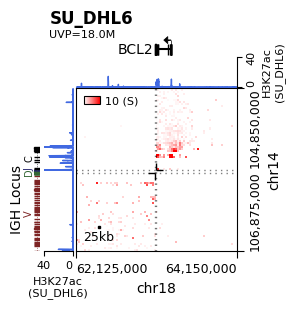

In [21]:
arima_sample = ArimaPipelineSample(sample.id_paper, sample.profile.hic, sample.profile.qc, sample.profile.curated)

bpoint = [bpoint for bpoint in arima_sample.breakpoints if bpoint.breakendA.chrom == "chr14" and bpoint.breakendB.chrom == "chr18"][0]
bpoint.breakendA, bpoint.breakendB = bpoint.breakendB, bpoint.breakendA
regionX, regionY = bpoint.get_centered_regions_with_radius(1000000)
resolution = 25000
regionX = regionX.get_bin_aligned(resolution)
regionY = regionY.get_bin_aligned(resolution)
gene_filter = ["BCL2"]
bw_tuple = (sample.id_paper, h3k27ac_dict[sample.id_paper])
fig  = plot_standard_matrix_plot(
    arima_sample, regionX, regionY, resolution, bw_tuple=bw_tuple, 
    figsize=(2.8,2.8),
    gene_filter=gene_filter, vmax=10, show_uvp=True)
fig.savefig(f"{arima_sample.id}_IGH_BCL2.svg")

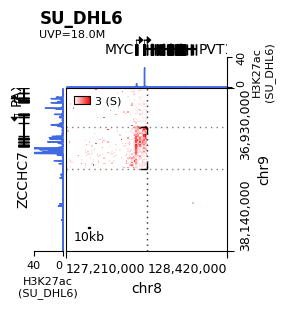

In [22]:
bpoint = [bpoint for bpoint in arima_sample.breakpoints if bpoint.breakendA.chrom == "chr8" and bpoint.breakendB.chrom == "chr9"][0]
gene_filter = ["MYC", "ZCCHC7", "PVT1", "PAX5"]

resolution = 10000
regionX, regionY = bpoint.get_centered_regions_with_radius(600000)
regionX = regionX.get_bin_aligned(resolution)
regionY = regionY.get_bin_aligned(resolution)

bw_tuple = (sample.id_paper, h3k27ac_dict[sample.id_paper])

fig  = plot_standard_matrix_plot(
    arima_sample, regionX, regionY, resolution, bw_tuple=bw_tuple, 
    figsize=(2.8,2.8),
    gene_filter=gene_filter, vmax=3, show_uvp=True)

ax = fig.get_axes()[2]
ax.findobj(plt.Text)[1].set_x(128210000)
ax.findobj(plt.Text)[1].set_ha("left")

ax = fig.get_axes()[1]
ax.findobj(plt.Text)[1].set_y(37600000)
ax.findobj(plt.Text)[1].set_va("top")
ax.findobj(plt.Text)[1].set_va("center")
ax.findobj(plt.Text)[0].set_y(36930000)
ax.findobj(plt.Text)[0].set_va("center")
ax.findobj(plt.Text)[0].set_ha("right")
fig.savefig(f"{arima_sample.id}_MYC_PAX5.svg")

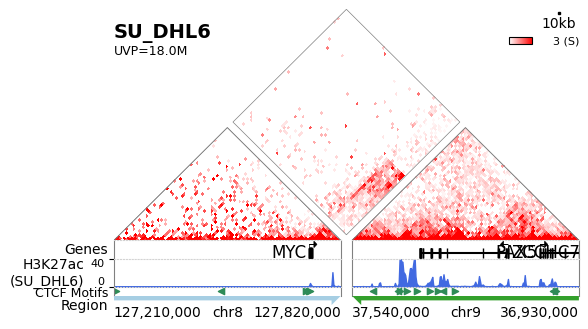

In [24]:
# bpoint specified above
regionLeft, regionRight = bpoint.get_reconstructed_regions_with_radius(600000)
resolution = 10000
regionLeft = regionLeft.get_bin_aligned(resolution)
regionRight = regionRight.get_bin_aligned(resolution)
assembly = [regionLeft, regionRight]
gene_filter = ["MYC", "ZCCHC7", "PAX5"]
# bw_tuple defined above

fig = plot_standard_triangle_plot(
    arima_sample, assembly, resolution,
    gene_filter=gene_filter, gap_size=3,
    show_uvp=True, show_neoloops=False,
    show_bw1_track=True,
    bw1_pair=bw_tuple,
    dot_size=25,
    show_compartment_track=False,
    show_triangle_arcs=False,
    show_loops=False,
    vmax=3,
    
)

fig.savefig(f"{arima_sample.id}_triangle_MYC_PAX5.svg", bbox_inches="tight")

# CL-5 RCK8

In [25]:
id_paper = "RCK8"

profile = DataProfile(
    hic=f"../data_extra/hic_outputs/{id_paper}/{id_paper}_inter_30.hic",
    qc=f"../data_extra/hic_outputs/{id_paper}/{id_paper}_v1.3_Arima_QC_deep.txt",
    breakfinder=None,
    mcool=None,
    cnv_profile=None,
    cnv_segment=None,
    eaglec=None,
    curated=f"../data_extra/hic_curated/{id_paper}_curated_breakpoints.bedpe",   
    curated_arima=f"../data_extra/hic_curated/{id_paper}_curated_breakpoints.bedpe",   
    compartments=None,
    tads=None,
    loops_hiccups=None,
    loops_hicexplorer=None,
    neoloops=f"../data/neoloops/90/{id_paper}.neoloops.bedpe",
    ogm="../data_extra/ogm_outputs/CL-5_RCK8 – Unclassified DLBCL.xlsx"
)

sample = Sample(
    id_paper=id_paper,
    meta=None,
    profile=profile,
)


print_qc(sample)

RCK8	407865615.0	668487620.0	81.9	38044298.0	17.0	18.1	64.9	0.0	5.7	23.0	20.9	14.3	0.9	4.4


In [26]:
ogm_events = parse_ogm_events(sample.profile.ogm)

In [27]:
hic_bpoints = parse_hic_breakpoints(sample.profile.curated_arima)

In [28]:
matched, unmatched_ogm, unmatched_hic = match_fusions(ogm_events, hic_bpoints)

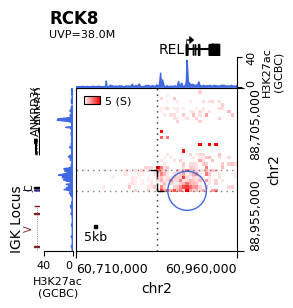

In [34]:
arima_sample = ArimaPipelineSample(sample.id_paper, sample.profile.hic, sample.profile.qc, sample.profile.curated)

bpoint = [bpoint for bpoint in arima_sample.breakpoints if bpoint.breakendA.chrom == "chr2" and bpoint.breakendB.chrom == "chr2"][1]
regionX, regionY = bpoint.get_centered_regions_with_radius(5000*25)
resolution = 5000
regionX = regionX.get_bin_aligned(resolution)
regionY = regionY.get_bin_aligned(resolution)
gene_filter = ["REL", "BCL6", ]
bw_tuple = (sample.id_paper, h3k27ac_dict[sample.id_paper])
fig  = plot_standard_matrix_plot(
    arima_sample, regionX, regionY, resolution, bw_tuple=("GCBC", "../annotations/H3K27ac/03_germinal_center_B_cell.H3K27ac.bw"), 
    figsize=(2.8,2.8),
    neoloop_region_filter=GenomicRegion("chr2", 60880000, 60885000), # REL
    gene_filter=gene_filter, vmax=5, show_uvp=True,
)

# Annotate ANKRD36BP2
ax_geneY = fig.axes[1]
plot_gene_track(regionY, gene_filter=["ANKRD36BP2"], vertical=True, ax=ax_geneY, max_rows=1, min_rows=0)#, centered_names=True)
ax_geneY.invert_xaxis()

fig.savefig(f"{arima_sample.id}_IGK_REL_zoom.svg", bbox_inches="tight")

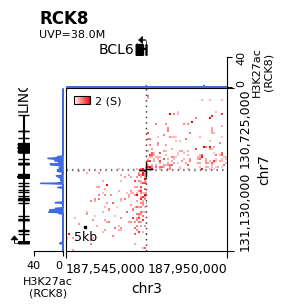

In [36]:
resolution = 5000
bpoint = [bpoint for bpoint in arima_sample.breakpoints if bpoint.breakendA.chrom == "chr3" and bpoint.breakendB.chrom == "chr7"][0]
regionX, regionY = bpoint.get_centered_regions_with_radius(resolution*40)
regionX = regionX.get_bin_aligned(resolution)
regionY = regionY.get_bin_aligned(resolution)
gene_filter = ["BCL6", "LINC-PINT", "LPP"]
bw_tuple = (sample.id_paper, h3k27ac_dict[sample.id_paper])
fig  = plot_standard_matrix_plot(
    arima_sample, regionX, regionY, resolution, bw_tuple=bw_tuple, 
    figsize=(2.8,2.8),
    neoloop_region_filter=GenomicRegion("chr3", 187745000, 187750000),
    gene_filter=gene_filter, vmax=2, show_uvp=True)
fig.savefig(f"{arima_sample.id}_BCL6_LINC-PINT.svg")

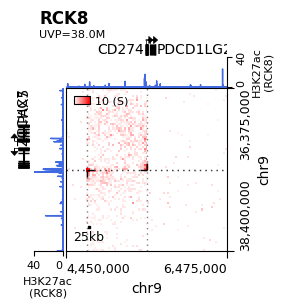

In [37]:
bpoint = [bpoint for bpoint in arima_sample.breakpoints if bpoint.breakendA.chrom == "chr9" and bpoint.breakendB.chrom == "chr9"][3]
regionX, regionY = bpoint.get_centered_regions_with_radius(1000000)
resolution = 25000
regionX = regionX.get_bin_aligned(resolution)
regionY = regionY.get_bin_aligned(resolution)
gene_filter = ["PAX5", "PDCD1LG2", "CD274", "ZCCHC7"]
bw_tuple = (sample.id_paper, h3k27ac_dict[sample.id_paper])
fig  = plot_standard_matrix_plot(
    arima_sample, regionX, regionY, resolution, bw_tuple=bw_tuple, 
    figsize=(2.8,2.8),
    gene_filter=gene_filter, vmax=10, show_uvp=True)

ax = fig.get_axes()[2]
ax.findobj(plt.Text)[1].set_x(5485218.5+1e5)
ax.findobj(plt.Text)[1].set_ha("left")
fig.savefig(f"{arima_sample.id}_CD274_PAX5.svg", bbox_inches="tight")
    

# CL-6 ANBL6

In [38]:
id_paper = "ANBL6"

profile = DataProfile(
    hic=f"../data_extra/hic_outputs/{id_paper}/{id_paper}_inter_30.hic",
    qc=f"../data_extra/hic_outputs/{id_paper}/{id_paper}_v1.3_Arima_QC_deep.txt",
    breakfinder=None,
    mcool=None,
    cnv_profile=None,
    cnv_segment=None,
    eaglec=None,
    curated=f"../data_extra/hic_curated/{id_paper}_curated_breakpoints.bedpe",
    curated_arima=f"../data_extra/hic_curated/{id_paper}_curated_breakpoints.bedpe",
    compartments=None,
    tads=None,
    loops_hiccups=None,
    loops_hicexplorer=None,
    neoloops=f"../data/neoloops/90/{id_paper}.neoloops.bedpe",
    ogm="../data_extra/ogm_outputs/CL-6_ANBL6 – multiple myeloma.xlsx"
)

sample = Sample(
    id_paper=id_paper,
    meta=None,
    profile=profile,
)
print_qc(sample)

ANBL6	576117914.0	932629734.0	80.9	56453942.0	17.9	16.5	65.6	0.0	6.7	21.0	21.6	15.5	0.8	5.1


In [39]:
ogm_events = parse_ogm_events(sample.profile.ogm)

In [40]:
hic_bpoints = parse_hic_breakpoints(sample.profile.curated_arima)

In [41]:
matched, unmatched_ogm, unmatched_hic = match_fusions(ogm_events, hic_bpoints)

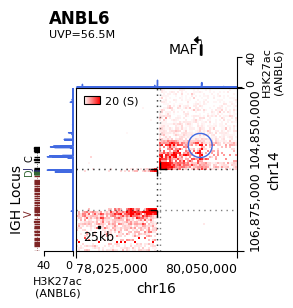

In [43]:
arima_sample = ArimaPipelineSample(sample.id_paper, sample.profile.hic, sample.profile.qc, sample.profile.curated)

bpoint = [bpoint for bpoint in arima_sample.breakpoints if bpoint.breakendA.chrom == "chr14" and bpoint.breakendB.chrom == "chr16"][0]
bpoint.breakendA, bpoint.breakendB = bpoint.breakendB, bpoint.breakendA
regionX, regionY = bpoint.get_centered_regions_with_radius(1000000)
resolution = 25000
regionX = regionX.get_bin_aligned(resolution)
regionY = regionY.get_bin_aligned(resolution)
gene_filter = ["MAF"]
bw_tuple = (sample.id_paper, h3k27ac_dict[sample.id_paper])
fig  = plot_standard_matrix_plot(
    arima_sample, regionX, regionY, resolution, bw_tuple=bw_tuple, 
    figsize=(2.8,2.8),
    show_neoloops=True,
    neoloop_region_filter=GenomicRegion("chr16", 79600000, 79625000), # MAF
    gene_filter=gene_filter, vmax=20, show_uvp=True)
fig.savefig(f"{arima_sample.id}_IGH_MAF.svg")

# CL-7 UoCB6

In [44]:
id_paper = "UOCB6"

profile = DataProfile(
    hic=f"../data_extra/hic_outputs/{id_paper}/{id_paper}_inter_30.hic",
    qc=f"../data_extra/hic_outputs/{id_paper}/{id_paper}_v1.3_Arima_QC_deep.txt",
    breakfinder=None,
    mcool=None,
    cnv_profile=None,
    cnv_segment=None,
    eaglec=None,
    curated=f"../data_extra/hic_curated/{id_paper}_curated_breakpoints.bedpe",
    curated_arima=f"../data_extra/hic_curated/{id_paper}_curated_breakpoints.bedpe",
    compartments=None,
    tads=None,
    loops_hiccups=None,
    loops_hicexplorer=None,
    neoloops=f"../data/neoloops/90/{id_paper}.neoloops.bedpe",
    ogm="../data_extra/ogm_outputs/CL-7_UoCB6.xlsx"
)

sample = Sample(
    id_paper=id_paper,
    meta=None,
    profile=profile,
)
print_qc(sample)

UOCB6	455806347.0	734580109.0	80.6	44106018.0	18.3	23.6	58.2	0.0	7.1	25.1	17.1	7.9	0.9	3.0


In [45]:
ogm_events = parse_ogm_events(sample.profile.ogm)

In [46]:
hic_bpoints = parse_hic_breakpoints(sample.profile.curated_arima)

In [47]:
matched, unmatched_ogm, unmatched_hic = match_fusions(ogm_events, hic_bpoints)

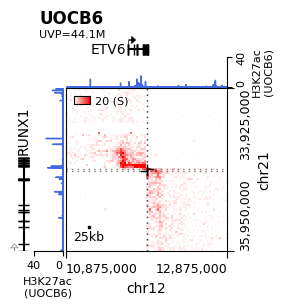

In [48]:
arima_sample = ArimaPipelineSample(sample.id_paper, sample.profile.hic, sample.profile.qc, sample.profile.curated)

bpoint = [bpoint for bpoint in arima_sample.breakpoints if bpoint.breakendA.chrom == "chr12" and bpoint.breakendB.chrom == "chr21"][0]
# bpoint.breakendA, bpoint.breakendB = bpoint.breakendB, bpoint.breakendA
regionX, regionY = bpoint.get_centered_regions_with_radius(1000000)
resolution = 25000
regionX = regionX.get_bin_aligned(resolution)
regionY = regionY.get_bin_aligned(resolution)
gene_filter = ["ETV6", "RUNX1"]
bw_tuple = (sample.id_paper, h3k27ac_dict[sample.id_paper])
fig  = plot_standard_matrix_plot(
    arima_sample, regionX, regionY, resolution, bw_tuple=bw_tuple, 
    figsize=(2.8,2.8),
    gene_filter=gene_filter, vmax=20, show_uvp=True, show_neoloops=False)
fig.savefig(f"{arima_sample.id}_ETV6_RUNX1.svg")

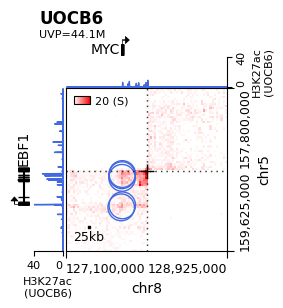

In [49]:
bpoint = [bpoint for bpoint in arima_sample.breakpoints if bpoint.breakendA.chrom == "chr5" and bpoint.breakendB.chrom == "chr8"][0]
if bpoint.breakendA.chrom == "chr5":
    bpoint.breakendA, bpoint.breakendB = bpoint.breakendB, bpoint.breakendA
regionX, regionY = bpoint.get_centered_regions_with_radius(900000)
resolution = 25000
regionX = regionX.get_bin_aligned(resolution)
regionY = regionY.get_bin_aligned(resolution)
gene_filter = ["MYC", "EBF1"]
bw_tuple = (sample.id_paper, h3k27ac_dict[sample.id_paper])

goi = GENE_ANNOTATIONS.genes_by_name("MYC")[0]
neoloop_region_filter = GenomicRegion(chr_prefix(goi.contig), goi.start-1e5, goi.end+1e5)
fig  = plot_standard_matrix_plot(
    arima_sample, regionX, regionY, resolution, bw_tuple=bw_tuple, 
    figsize=(2.8,2.8),
    gene_filter=gene_filter, vmax=20, show_uvp=True,
    neoloop_region_filter=neoloop_region_filter
)
fig.savefig(f"{arima_sample.id}_MYC_EBF1.svg")

# WSU-DLCL2

In [50]:
id_paper = "WSU_DLCL2"

profile = DataProfile(
    hic=f"../data_extra/hic_outputs/{id_paper}_rep1/{id_paper}_rep1_inter_30.hic",
    qc=f"../data_extra/hic_outputs/{id_paper}_rep1/{id_paper}_rep1_v1.3_Arima_QC_deep.txt",
    breakfinder=None,
    mcool=None,
    cnv_profile=None,
    cnv_segment=None,
    eaglec=None,
    curated=f"../data_extra/hic_curated/{id_paper}_curated_breakpoints.bedpe",
    curated_arima=f"../data_extra/hic_curated/{id_paper}_curated_breakpoints.bedpe",
    compartments=None,
    tads=None,
    loops_hiccups=None,
    loops_hicexplorer=None,
    neoloops=f"../data/neoloops/90/{id_paper}.neoloops.bedpe",
    ogm="../data_extra/ogm_outputs/WSU-DLCL2.xlsx"
)

sample = Sample(
    id_paper=id_paper,
    meta=None,
    profile=profile,
)
print_qc(sample)

WSU_DLCL2	502634259.0	795865917.0	79.2	22867203.0	8.9	30.2	60.9	0.0	6.4	28.2	17.2	8.1	1.0	2.5


In [51]:
ogm_events = parse_ogm_events(sample.profile.ogm)

In [52]:
hic_bpoints = parse_hic_breakpoints(sample.profile.curated_arima)

In [53]:
matched, unmatched_ogm, unmatched_hic = match_fusions(ogm_events, hic_bpoints)

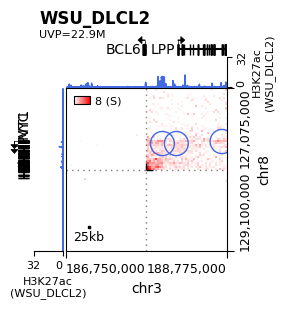

In [54]:
arima_sample = ArimaPipelineSample(sample.id_paper, sample.profile.hic, sample.profile.qc, sample.profile.curated)

bpoint = [bpoint for bpoint in arima_sample.breakpoints if bpoint.breakendA.chrom == "chr3" and bpoint.breakendB.chrom == "chr8"][1]
# bpoint.breakendA, bpoint.breakendB = bpoint.breakendB, bpoint.breakendA
regionX, regionY = bpoint.get_centered_regions_with_radius(1000000)
resolution = 25000
regionX = regionX.get_bin_aligned(resolution)
regionY = regionY.get_bin_aligned(resolution)
gene_filter = ["MYC", "BCL6", "PVT1", "LPP"]
bw_tuple = (sample.id_paper, h3k27ac_dict[sample.id_paper])

goi = GENE_ANNOTATIONS.genes_by_name("MYC")[0]
neoloop_region_filter = GenomicRegion(chr_prefix(goi.contig), goi.start-resolution, goi.start+resolution)

fig  = plot_standard_matrix_plot(
    arima_sample, regionX, regionY, resolution, bw_tuple=bw_tuple, 
    figsize=(2.8,2.8),
    gene_filter=gene_filter, vmax=8, show_uvp=True, neoloop_region_filter=neoloop_region_filter, bw_max=32)
fig.savefig(f"{arima_sample.id}_MYC_BCL6.svg")

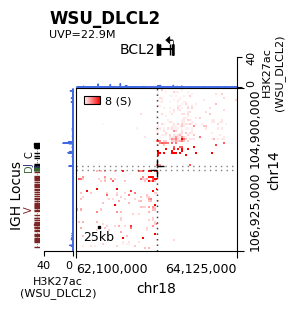

In [55]:
bpoint = [bpoint for bpoint in arima_sample.breakpoints if bpoint.breakendA.chrom == "chr14" and bpoint.breakendB.chrom == "chr18"][1]
bpoint.breakendA, bpoint.breakendB = bpoint.breakendB, bpoint.breakendA
regionX, regionY = bpoint.get_centered_regions_with_radius(1000000)
resolution = 25000
regionX = regionX.get_bin_aligned(resolution)
regionY = regionY.get_bin_aligned(resolution)
gene_filter = ["BCL2"]
bw_tuple = (sample.id_paper, h3k27ac_dict[sample.id_paper])
fig  = plot_standard_matrix_plot(
    arima_sample, regionX, regionY, resolution, bw_tuple=bw_tuple, 
    figsize=(2.8,2.8),
    gene_filter=gene_filter, vmax=8, show_uvp=True)
fig.savefig(f"{arima_sample.id}_BCL2_IGH.svg")

# Circos

In [70]:
from pycirclize import Circos
from collections import defaultdict
from pycirclize.utils import ColorCycler, load_eukaryote_example_dataset

In [77]:
def plot_circos_ogm(id_paper, ogm_events, hic_bpoints, figsize=(4,4), highlight_events=[]):
    # Load hg38 dataset (https://github.com/moshi4/pycirclize-data/tree/main/eukaryote/hg38)
    chr_bed_file, cytoband_file, chr_links = load_eukaryote_example_dataset("hg38")
    
    # Initialize Circos from BED chromosomes
    circos = Circos.initialize_from_bed(chr_bed_file, space=3)
    circos.text(f"{id_paper} OGM\n(Interchr)", deg=315, r=150, size=12)
    
    # Add cytoband tracks from cytoband file
    circos.add_cytoband_tracks((95, 100), cytoband_file)
    
    # Create chromosome color dict
    ColorCycler.set_cmap("hsv")
    chr_names = [s.name for s in circos.sectors]
    colors = ColorCycler.get_color_list(len(chr_names))
    chr_name2color = {name: color for name, color in zip(chr_names, colors)}
    
    # # Plot chromosome name & xticks
    for sector in circos.sectors:
        sector.text(chr_unprefix(sector.name), r=105, size=10, color="black")
    
    # # Plot chromosome link
    for ogm_event in ogm_events:
        if ogm_event.event_type == "Interchr Translocation":
            region1 = (ogm_event.fusion_junction1a.chrom, ogm_event.fusion_junction1a.pos)
            region2 = (ogm_event.fusion_junction1b.chrom, ogm_event.fusion_junction1b.pos)
            color = "black"
            for (chrom1, range1, chrom2, range2, event_color) in highlight_events:
                if region1[0] == chrom1 and range1[0] <= region1[1] <= range1[1] and region2[0] == chrom2 and range2[0] <= region2[1] <= range2[1]:
                    color = event_color
                elif region2[0] == chrom1 and range1[0] <= region2[1] <= range1[1] and region1[0] == chrom2 and range2[0] <= region1[1] <= range2[1]: 
                    color = event_color
            circos.link_line(region1, region2, color=color)
    
    fig = circos.plotfig(figsize=figsize)
    fig.savefig(f"{id_paper}_circos_ogm.svg", bbox_inches="tight")
    return fig

In [99]:
def plot_circos_hic(id_paper, ogm_events, hic_bpoints, figsize=(4,4), highlight_events=[]):
    # Load hg38 dataset (https://github.com/moshi4/pycirclize-data/tree/main/eukaryote/hg38)
    chr_bed_file, cytoband_file, chr_links = load_eukaryote_example_dataset("hg38")
    
    # Initialize Circos from BED chromosomes
    circos = Circos.initialize_from_bed(chr_bed_file, space=3)
    circos.text(f"{id_paper} Hi-C\n(Interchr)", deg=315, r=150, size=12)
    
    # Add cytoband tracks from cytoband file
    circos.add_cytoband_tracks((95, 100), cytoband_file)
    
    # Create chromosome color dict
    ColorCycler.set_cmap("hsv")
    chr_names = [s.name for s in circos.sectors]
    colors = ColorCycler.get_color_list(len(chr_names))
    chr_name2color = {name: color for name, color in zip(chr_names, colors)}
    
    # # Plot chromosome name & xticks
    for sector in circos.sectors:
        sector.text(chr_unprefix(sector.name), r=105, size=10, color="black")
    
    # # Plot chromosome link
    for bpoint in hic_bpoints:
        if bpoint.breakendA.chrom != bpoint.breakendB.chrom:
            try:
                # region1 = (bpoint.breakendA.chrom, bpoint.breakendA.pos, bpoint.breakendA.pos)
                # region2 = (bpoint.breakendB.chrom, bpoint.breakendB.pos, bpoint.breakendB.pos)
                # color = chr_name2color[ogm_event.fusion_junction1a.chrom]
                region1 = (bpoint.breakendA.chrom, bpoint.breakendA.pos)
                region2 = (bpoint.breakendB.chrom, bpoint.breakendB.pos)
                color = "black"
                for (chrom1, range1, chrom2, range2, event_color) in highlight_events:
                    if region1[0] == chrom1 and range1[0] <= region1[1] <= range1[1] and region2[0] == chrom2 and range2[0] <= region2[1] <= range2[1]:
                        color = event_color
                    elif region2[0] == chrom1 and range1[0] <= region2[1] <= range1[1] and region1[0] == chrom2 and range2[0] <= region1[1] <= range2[1]: 
                        color = event_color
                circos.link_line(region1, region2, color=color)
            except e:
                pass

    fig = circos.plotfig(figsize=figsize)
    fig.savefig(f"{id_paper}_circos_hic.svg", bbox_inches="tight")
    return fig

## SU_DHL6

In [108]:
id_paper = "SU_DHL6"

profile = DataProfile(
    hic=f"../data_extra/hic_outputs/{id_paper}/{id_paper}_inter_30.hic",
    qc=f"../data_extra/hic_outputs/{id_paper}/{id_paper}_v1.3_Arima_QC_deep.txt",
    breakfinder=None,
    mcool=None,
    cnv_profile=None,
    cnv_segment=None,
    eaglec=None,
    curated=f"../data_extra/hic_curated/{id_paper}_curated_breakpoints.bedpe",
    curated_arima=f"../data_extra/hic_curated/{id_paper}_curated_breakpoints.bedpe",
    compartments=None,
    tads=None,
    loops_hiccups=None,
    loops_hicexplorer=None,
    neoloops=None,
    ogm="../data_extra/ogm_outputs/CL-2 _SU-DHL-6 – GCB-DLBCL.xlsx"
)

sample = Sample(
    id_paper=id_paper,
    meta=None,
    profile=profile,
)

ogm_events = parse_ogm_events(sample.profile.ogm)
hic_bpoints = parse_hic_breakpoints(sample.profile.curated_arima)

highlight_events = [
    ("chr14", (105890000, 105910000), "chr18", (63120000, 63160000), "crimson"), # IGH::BCL2,
    ("chr8", (127800000, 127900000), "chr9", (37218000, 37219000), "royalblue") # PAX5/ZCCHC7::MYC,
]

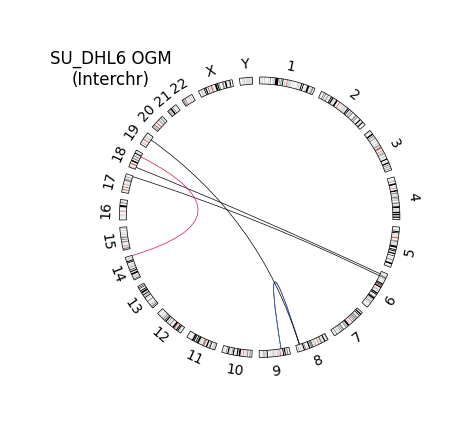

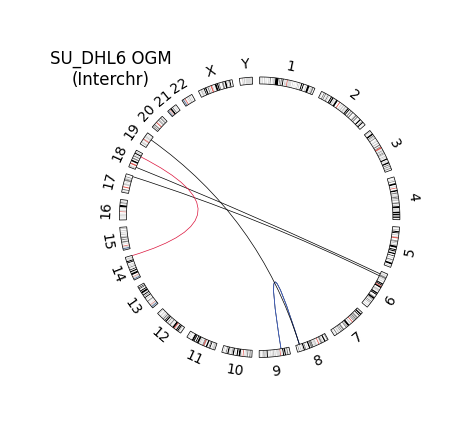

In [109]:
plot_circos_ogm(id_paper, ogm_events, hic_bpoints, highlight_events=highlight_events)

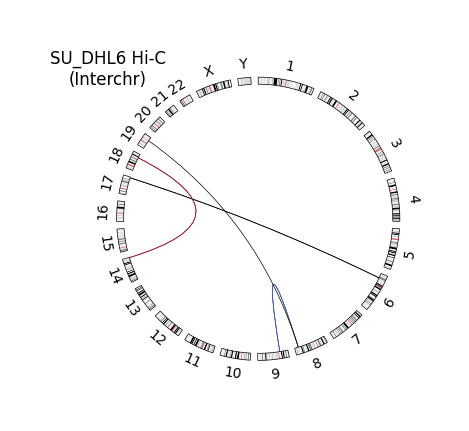

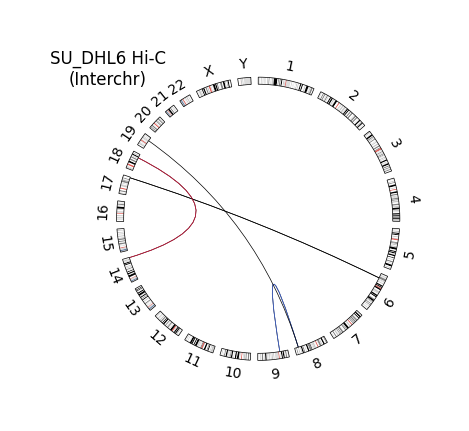

In [110]:
plot_circos_hic(id_paper, ogm_events, hic_bpoints, highlight_events=highlight_events)

## RCK8

In [115]:

id_paper = "RCK8"

profile = DataProfile(
    hic=f"../data_extra/hic_outputs/{id_paper}/{id_paper}_inter_30.hic",
    qc=f"../data_extra/hic_outputs/{id_paper}/{id_paper}_v1.3_Arima_QC_deep.txt",
    breakfinder=None,
    mcool=None,
    cnv_profile=None,
    cnv_segment=None,
    eaglec=None,
    curated=f"../data_extra/hic_curated/{id_paper}_curated_breakpoints.bedpe",   
    curated_arima=f"../data_extra/hic_curated/{id_paper}_curated_breakpoints.bedpe",   
    compartments=None,
    tads=None,
    loops_hiccups=None,
    loops_hicexplorer=None,
    neoloops=None,
    ogm="../data_extra/ogm_outputs/CL-5_RCK8 – Unclassified DLBCL.xlsx"
)

sample = Sample(
    id_paper=id_paper,
    meta=None,
    profile=profile,
)
ogm_events = parse_ogm_events(sample.profile.ogm)
hic_bpoints = parse_hic_breakpoints(sample.profile.curated_arima)

highlight_events = [
    ("chr3", (187600000, 187800000), "chr7", (130000000, 131000000), "royalblue") # BCL6::LINC-PINT
]

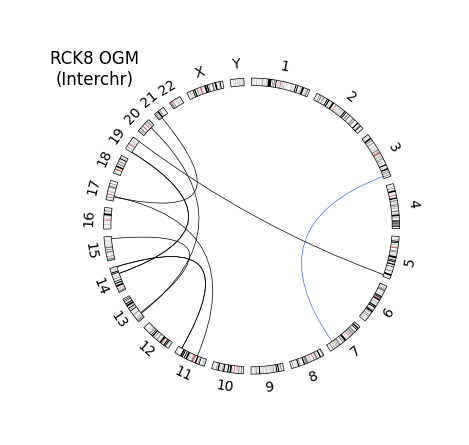

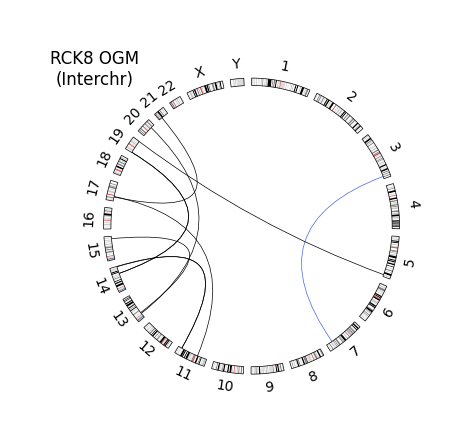

In [116]:
plot_circos_ogm(id_paper, ogm_events, hic_bpoints, highlight_events=highlight_events)

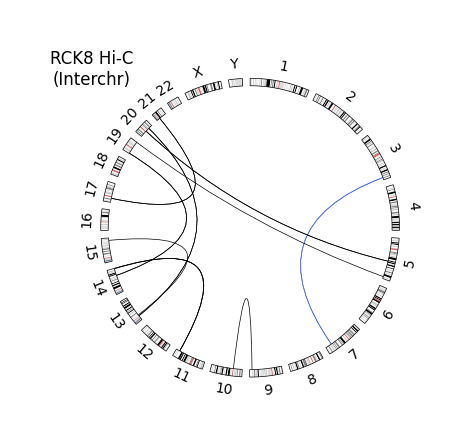

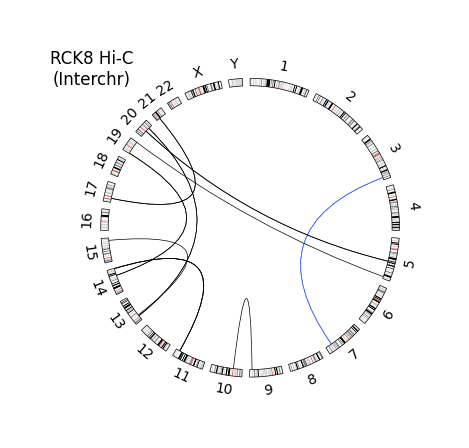

In [118]:
plot_circos_hic(id_paper, ogm_events, hic_bpoints, highlight_events=highlight_events)

## ANBL6

In [134]:

id_paper = "ANBL6"

profile = DataProfile(
    hic=f"../data_extra/hic_outputs/{id_paper}/{id_paper}_inter_30.hic",
    qc=f"../data_extra/hic_outputs/{id_paper}/{id_paper}_v1.3_Arima_QC_deep.txt",
    breakfinder=None,
    mcool=None,
    cnv_profile=None,
    cnv_segment=None,
    eaglec=None,
    curated=f"../data_extra/hic_curated/{id_paper}_curated_breakpoints.bedpe",
    curated_arima=f"../data_extra/hic_curated/{id_paper}_curated_breakpoints.bedpe",
    compartments=None,
    tads=None,
    loops_hiccups=None,
    loops_hicexplorer=None,
    neoloops=None,
    ogm="../data_extra/ogm_outputs/CL-6_ANBL6 – multiple myeloma.xlsx"
)

sample = Sample(
    id_paper=id_paper,
    meta=None,
    profile=profile,
)

ogm_events = parse_ogm_events(sample.profile.ogm)
hic_bpoints = parse_hic_breakpoints(sample.profile.curated_arima)

highlight_events = [
    ("chr14", (105500000, 106500000), "chr16", (75000000, 80000000), "crimson")
]

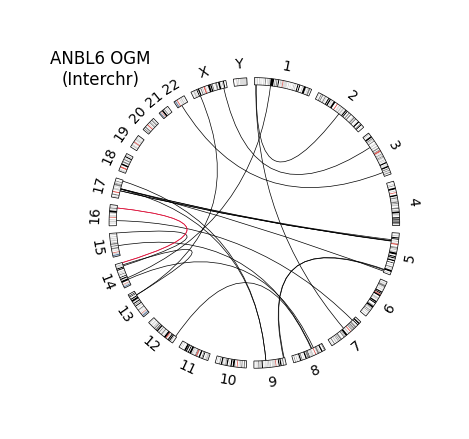

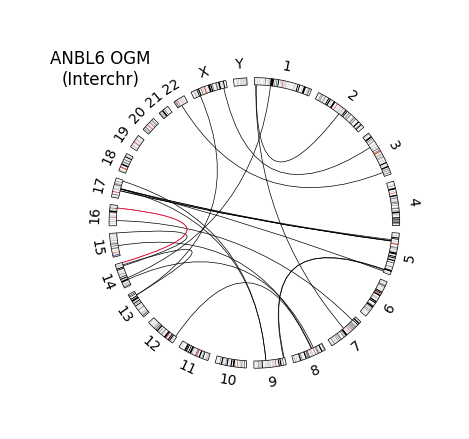

In [135]:
plot_circos_ogm(id_paper, ogm_events, hic_bpoints, highlight_events=highlight_events)

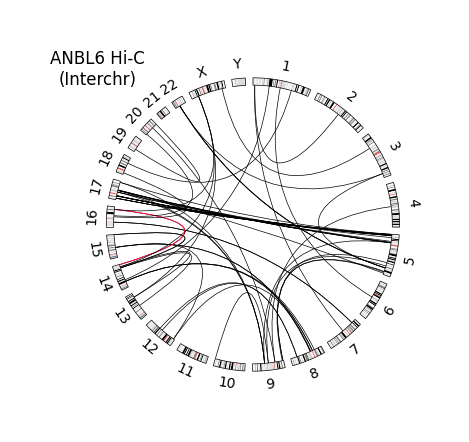

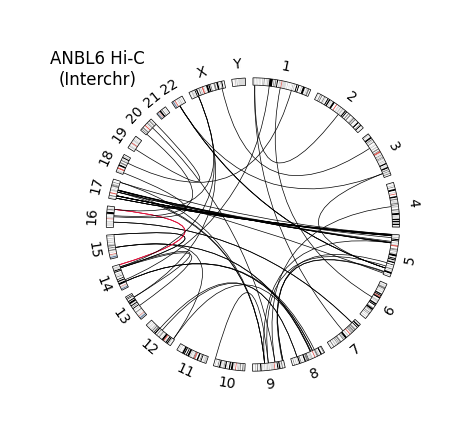

In [136]:
plot_circos_hic(id_paper, ogm_events, hic_bpoints, highlight_events=highlight_events)

## UoCB6

In [125]:
id_paper = "UOCB6"

profile = DataProfile(
    hic=f"../data_extra/hic_outputs/{id_paper}/{id_paper}_inter_30.hic",
    qc=f"../data_extra/hic_outputs/{id_paper}/{id_paper}_v1.3_Arima_QC_deep.txt",
    breakfinder=None,
    mcool=None,
    cnv_profile=None,
    cnv_segment=None,
    eaglec=None,
    curated=f"../data_extra/hic_curated/{id_paper}_curated_breakpoints.bedpe",
    curated_arima=f"../data_extra/hic_curated/{id_paper}_curated_breakpoints.bedpe",
    compartments=None,
    tads=None,
    loops_hiccups=None,
    loops_hicexplorer=None,
    neoloops=None,
    ogm="../data_extra/ogm_outputs/CL-7_UoCB6.xlsx"
)

sample = Sample(
    id_paper=id_paper,
    meta=None,
    profile=profile,
)
ogm_events = parse_ogm_events(sample.profile.ogm)
hic_bpoints = parse_hic_breakpoints(sample.profile.curated_arima)

highlight_events = [
    ("chr12", (11800000, 11900000), "chr21", (34000000, 35000000), "crimson"), # ETV6::RUNX1
    ("chr5",(158000000, 159000000),	"chr8", (128000000, 129000000), "royalblue"), # EBF1::MYC
    
]

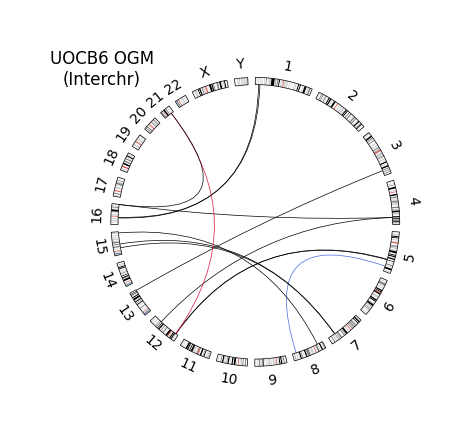

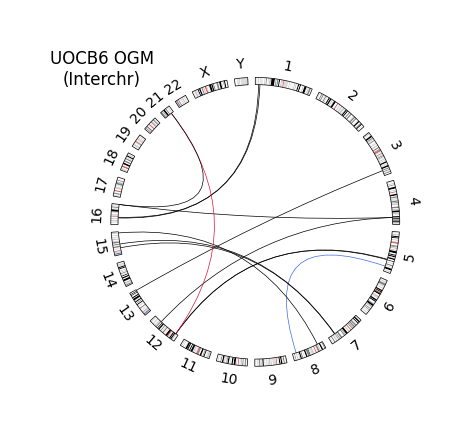

In [126]:
plot_circos_ogm(id_paper, ogm_events, hic_bpoints, highlight_events=highlight_events)

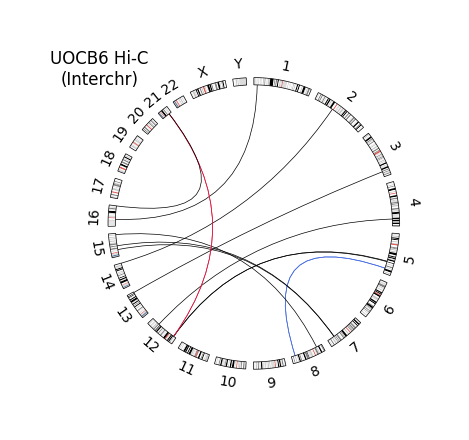

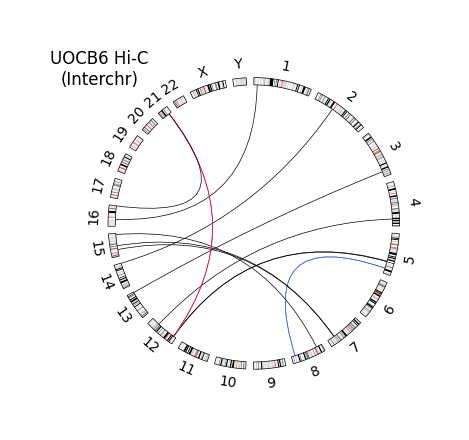

In [127]:
plot_circos_hic(id_paper, ogm_events, hic_bpoints, highlight_events=highlight_events)

## WSU-DLCL2

In [129]:
id_paper = "WSU_DLCL2"

profile = DataProfile(
    hic=f"../data_extra/hic_outputs/{id_paper}_rep1/{id_paper}_rep1_inter_30.hic",
    qc=f"../data_extra/hic_outputs/{id_paper}_rep1/{id_paper}_rep1_v1.3_Arima_QC_deep.txt",
    breakfinder=None,
    mcool=None,
    cnv_profile=None,
    cnv_segment=None,
    eaglec=None,
    curated=f"../data_extra/hic_curated/{id_paper}_curated_breakpoints.bedpe",
    curated_arima=f"../data_extra/hic_curated/{id_paper}_curated_breakpoints.bedpe",
    compartments=None,
    tads=None,
    loops_hiccups=None,
    loops_hicexplorer=None,
    neoloops=None,
    ogm="../data_extra/ogm_outputs/WSU-DLCL2.xlsx"
)

sample = Sample(
    id_paper=id_paper,
    meta=None,
    profile=profile,
)
ogm_events = parse_ogm_events(sample.profile.ogm)
hic_bpoints = parse_hic_breakpoints(sample.profile.curated_arima)

highlight_events = [
    ("chr14",(105000000,106000000), "chr18",(63000000, 64000000), "crimson",) ,
    ("chr3" ,(187000000,188000000), "chr8", (128000000, 129000000), "royalblue")
]

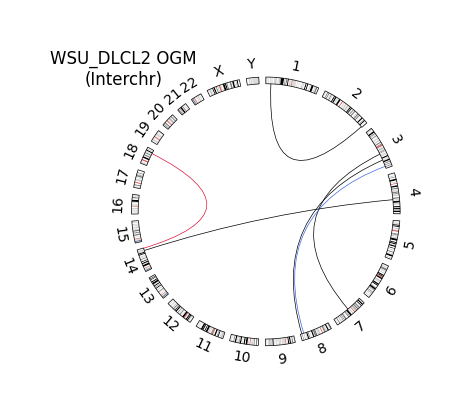

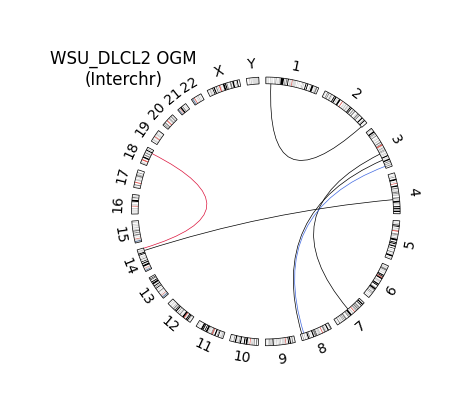

In [132]:
plot_circos_ogm(id_paper, ogm_events, hic_bpoints, highlight_events=highlight_events)

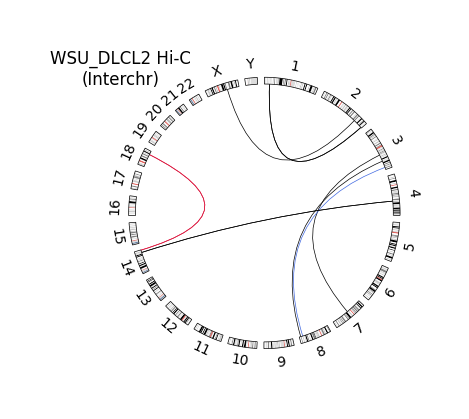

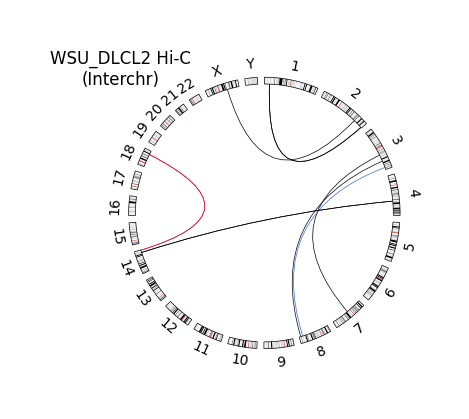

In [133]:
plot_circos_hic(id_paper, ogm_events, hic_bpoints, highlight_events=highlight_events)